# Test building a LIM using model data

Orignated: Greg Hakim, October 2020  

### This code does the following:

* reads TAS or SST data from CCSM4 CMIP5 LM simulation
* regrids tp a 4x5 grid
* checks regrid with some plots
* compute EOFs
 -  first normalize by sqrt(lat)
* plot EOFs
* project onto EOFs
* calibrate the LIM for a chosen lag
* tests the LIM for a range of forecast lead times, for training the validation datasets
* validates the LIM on similar forecasts of 20CR data
* solve for noise covariance
* numerical integration
 - check ensemble variance
 - test sum of deterministic IC ensemble variance, and ensemble variance from noise 
* save LIM parameters to a file
 - eigenvectors and eigenvalues
 - steady-state noise covariance matrix and square root
 - time-dependent noise covariance matrix
* ---beyond here is testing code---
* tau tests


In [1]:
# Define of the name of the variable to use for the LIM
var_to_extract = 'tas'
# tos is not working due to mask issues...
#var_to_extract = 'tos'

# number of EOFs to retain for the LIM state vector
nmodes = 20

# forecast lead time in months that defines the LIM training
tau = 6

# training data defined by the first ntrain times
ntrain = 4000

# for the LIM readme
data_source = 'CCSM4 last millennium simulation'


In [2]:
import sys,os
#sys.path.append("/Users/hakim/gitwork/LMR_python3")
sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")

In [3]:
from netCDF4 import Dataset, date2num, num2date
import numpy as np
import ESMF
import LMR_utils
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point

In [4]:
import time as timestamp # avoids conflict with local naming!

In [5]:
pi = np.pi

# fill continents if plotting SST; otherwise no
if var_to_extract == 'tos':
    noland = True
else:
    noland = False
    
# netcdf file locations
#ccsm_dir = '/Users/hakim/data/LMR_python3/data/model/ccsm4_last_millenium/'
ccsm_dir = '/home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/'

infile_ccsm_tos = (ccsm_dir + 'tos_sfc_Omon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_tas = (ccsm_dir + 'tas_sfc_Amon_CCSM4_past1000_085001-185012.nc')
infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

In [6]:
#----------- start of function definitions --------------

In [8]:
def load_data(var_to_extract,infile):
    
    """This function does all of the gridded data loading and processing"""
    
    print('fetching ',var_to_extract,' from ',infile)
    
    # open the file
    data = Dataset(infile,'r')
    
    # this block hacked from load_gridded_data

    # Dimensions used to store the data
    nc_dims = [dim for dim in data.dimensions]
    dictdims = {}
    for dim in nc_dims:
        dictdims[dim] = len(data.dimensions[dim])

    # Query its dimensions
    vardims = data.variables[var_to_extract].dimensions
    nbdims  = len(vardims)
    # names of variable dims
    vardimnames = []
    for d in vardims:
        vardimnames.append(d)

    # put everything in lower case for homogeneity
    vardimnames = [item.lower() for item in vardimnames]

    # extract info on variable units
    units = data.variables[var_to_extract].units

    # time variable
    time = data.variables['time']

    # Transform into calendar dates using netCDF4 variable attributes (units & calendar)
    try:
        if hasattr(time, 'calendar'):
            # if time is defined as "months since":not handled by datetime functions
            if 'months since' in time.units:
                new_time = np.zeros(time.shape)
                nmonths, = time.shape
                basedate = time.units.split('since')[1].lstrip()
                new_time_units = "days since "+basedate        
                start_date = pl.datestr2num(basedate)        
                act_date = start_date*1.0
                new_time[0] = act_date
                for i in range(int(nmonths)): #increment months
                    d = pl.num2date(act_date)
                    ndays = monthrange(d.year,d.month)[1] #number of days in current month
                    act_date += ndays
                    new_time[i] = act_date

                time_yrs = num2date(new_time[:],units=new_time_units,calendar=time.calendar)
            else:                    
                time_yrs = num2date(time[:],units=time.units,
                                calendar=time.calendar)
        else:
            time_yrs = num2date(time[:],units=time.units)
        time_yrs_list = time_yrs.tolist()
        
    except ValueError:
        # num2date needs calendar year start >= 0001 C.E. (bug submitted
        # to unidata about this
        fmt = '%Y-%d-%m %H:%M:%S'
        tunits = time.units
        since_yr_idx = tunits.index('since ') + 6
        year = int(tunits[since_yr_idx:since_yr_idx+4])
        year_diff = year - 1
        new_start_date = datetime(1, 1, 1, 0, 0, 0)

        new_units = tunits[:since_yr_idx] + '0001-01-01 00:00:00'
        if hasattr(time, 'calendar'):
            time_yrs = num2date(time[:], new_units, calendar=time.calendar)
        else:
            time_yrs = num2date(time[:], new_units)

        time_yrs_list = [datetime(d.year + year_diff, d.month, d.day,
                                  d.hour, d.minute, d.second)
                         for d in time_yrs]
        
    # this loads the data
    begin_time = timestamp.time()
    data_var = data.variables[var_to_extract][:]
    elapsed_time = timestamp.time() - begin_time
    print('-----------------------------------------------------')
    print('completed in ' + str(elapsed_time) + ' seconds')
    print('-----------------------------------------------------')
    
    return data, data_var, vardimnames, time_yrs

In [9]:
def set_coord_names(data, data_var, vardimnames):
    # coordinate setup
    varspacecoordnames = [item for item in vardimnames if item != 'time'] 
    varspacecoordnames = [item for item in varspacecoordnames if item != 'plev'] 
    spacecoords = (varspacecoordnames[0],varspacecoordnames[1])
    spacevar1 = data.variables[spacecoords[0]][:]
    spacevar2 = data.variables[spacecoords[1]][:]
    vardims = data_var.shape
    print(vardims)

    # which dim is lat & which is lon?
    indlat = spacecoords.index('lat')
    indlon = spacecoords.index('lon')
    print('indlat=', indlat, ' indlon=', indlon)

    ntime = len(data.dimensions['time'])

    print(spacecoords)

    if var_to_extract == 'tos':
        lat_2d_orig = spacevar1
        lon_2d_orig = spacevar2
    else:
        lat_2d_orig = spacevar1[:,np.newaxis]*np.ones(spacevar2[:,np.newaxis].shape[0])
        lon_2d_orig = np.ones([spacevar1[:,np.newaxis].shape[0],1])*spacevar2
    
    return ntime, lat_2d_orig, lon_2d_orig

In [10]:
def regrid_data(data_var, ntime, lat_2d_orig, lon_2d_orig, nlat, nlon):
    #----- regrid the data to lower resolution
    begin_time = timestamp.time()
    
    nlat_orig = lat_2d_orig.shape[0]
    nlon_orig = lon_2d_orig.shape[1]
    print('nlat:',nlat_orig)
    print('nlon:',nlon_orig)

    datax = np.reshape(data_var,[ntime,nlat_orig*nlon_orig])
    # shift to (nx,nens) shaping for regridding function
    tmp = np.moveaxis(datax,0,-1)
    print(tmp.shape)

    # this is the new grid
#     nlat = 45
#     nlon = 72
    ndof = nlat*nlon
    nens = ntime

    # regrid using LMR regrid function, which uses ESMpy
    [data_new,
     lat_2d,
     lon_2d] = LMR_utils.regrid_esmpy(nlat,
                                       nlon,
                                       nens,
                                       tmp,
                                       lat_2d_orig,
                                       lon_2d_orig,
                                       nlat_orig,
                                       nlon_orig)

    elapsed_time = timestamp.time() - begin_time
    print('-----------------------------------------------------')
    print('completed in ' + str(elapsed_time) + ' seconds')
    print('-----------------------------------------------------')
    
    return data_new, lat_2d, lon_2d

In [11]:
def compute_climo(data_new, time_yrs, ntime, nlat, nlon): 
    # compute monthly average and remove from the original data
    dates = time_yrs

    # shape back back to (ntime,nlat,nlon)
    data_new2 = np.reshape(np.moveaxis(data_new,0,-1),[ntime,nlat,nlon])
    climo_month = np.zeros([12,nlat,nlon], dtype=float)
    print('Working on:')
    for i in range(12):
        print('month = '+str(i))
        m = i+1
        indsm = [j for j,v in enumerate(dates) if v.month == m]
        indsmref = indsm

        climo_month[i] = np.nanmean(data_new2[indsmref], axis=0)
        data_new2[indsm] = (data_new2[indsm] - climo_month[i])
        # NEW---option to standardize monthly anomalies
        mostd = np.std(data_new2[indsm],axis=0,ddof=1)
        data_new2[indsm] = data_new2[indsm]/mostd

        # GH: make an array with month and year at some point?
    
    return data_new2

In [12]:
def get_data(var_to_extract,infile, nlat, nlon):
    
    data, data_var, vardimnames, time_yrs = load_data(var_to_extract,infile)
    ntime, lat_2d_orig, lon_2d_orig = set_coord_names(data, data_var, vardimnames)
    data_new, lat_2d, lon_2d = regrid_data(data_var, ntime, lat_2d_orig, lon_2d_orig, nlat, nlon)
    data_new2 = compute_climo(data_new, time_yrs, ntime, nlat, nlon)
    
    return data_new2,lat_2d,lon_2d

In [13]:
def LIM_train(tau,x_train):
    """
    train a LIM, L, given a training dataset
    
    Inputs:
    * tau: the training lag time (unitless) in time steps defined by the format of x_train
    * x_train: ~(nx,nt) state-time matrix
    
    Outputs:
    * LIMd: a dictionary containing the left eigenvectors of L, their inverse, and the eigenvalues of L
    
    """
    nx = x_train.shape[0]
    nt = x_train.shape[1]
    
    # estimate of zero-lag covariance
    C_0 = np.matmul(x_train,x_train.T)/(nt-1)

    # lag-tau covariance
    C_1 = np.matmul(x_train[:,tau:],x_train[:,:-tau].T)/(nt-1)

    # lag-tau resolvant
    G = np.matmul(C_1,np.linalg.inv(C_0))

    # solve for L from G
    val,vec = np.linalg.eig(G)
    veci = np.linalg.inv(vec)
    lam = np.log(val)/tau
    
    # make a dictionary with the results
    LIMd = {}
    LIMd['vec'] = vec
    LIMd['veci'] = veci
    LIMd['lam'] = lam
    
    return LIMd

In [14]:
def LIM_forecast(LIMd,x,lags,E):
    """
    deterministic forecasting experiments for states in x and time lags in lags.

    Inputs:
    * LIMd: a dictionary with LIM attributes
    * x: a state-time matrix for initial conditions and verification ~(ndof,ntims)
    * lags: list of time lags for deterministic forecasts
    * E: the linear map from the coordinates of the LIM to physical (lat,lon) coordinates ~(nx*ny,ndof)
    
    Outputs (in a dictionary):
    * error variance as a function of space and forecast lead time ~(ndof,ntims)
    * the forecast states ~(nlags,ndof,ntims)
    """
    
    ndof = x.shape[0]
    ntims = x.shape[1]
    nlags = len(lags)
    nx = E.shape[0]
    
    error = np.zeros([nx,nlags])
    x_predict_save = np.zeros([nlags,ndof,ntims])
    
    k = -1
    for t in lags:
        k+=1
        print('t=',t)
        # make the propagator for this lead time
        Gt = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
        
        # forecast
        if t == 0:
            # need to handle this time separately, or the matrix dimension is off
            x_predict = np.matmul(Gt,x)
            x_predict_save[k,:,:] = x_predict
        else:
            x_predict = np.matmul(Gt,x[:,:-t])
            x_predict_save[k,:,:-t] = x_predict

        # physical-space fields for forecast and truth for this forecast lead time ~(ndof,ntims)
        X_predict = np.real(np.matmul(E,x_predict))
        X_truth = np.real(np.matmul(E,x[:,t:]))
        
        # error variance as a function of space and forecast lead time ~(ndof,ntims)
        error[:,k] = np.var(X_predict - X_truth,axis=1,ddof=1)
    
        # return the LIM forecast error dictionary
        LIMfd = {}
        LIMfd['error'] = error
        LIMfd['x_forecast'] = x_predict_save
        
    return LIMfd

In [85]:
def plot_map_vector(vec,lat,lon,minv=-1,maxv=-1,noland=False,cmap='bwr'):
    nlat = lat.shape[0]
    nlon = lon.shape[1]
    pdat = np.reshape(vec,[nlat,nlon])
    pdat_wrap, lon_wrap = add_cyclic_point(pdat,coord=lon[0,:], axis=1)
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=0.),zorder=1)
    ax.coastlines()
    if maxv == -1:
        maxv = np.nanmax(vec)
    if minv == -1:
        minv = -maxv
    cs = ax.pcolormesh(lon_wrap,lat[:,0],pdat_wrap,transform=ccrs.PlateCarree(),cmap=cmap,shading='flat',vmin=minv,vmax=maxv)
    plt.colorbar(cs, extend='both', shrink=0.6)
    if noland:
        ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black',facecolor='black')
    return

In [16]:
def euler_twostep(L,Qsr,dt,y_old):
    # stochastic integration scheme
    n = L.shape[0]
    # this has unit variance
    noise = np.random.randn(n,1)
    y_new = y_old + dt*np.matmul(L,y_old) + np.sqrt(dt)*np.matmul(Qsr,noise)
    x_new = 0.5*(y_new + y_old)
    return x_new,y_new

In [17]:
#----------- end of function definitions --------------

In [18]:
#
# load CCSM4 past1000 data...
#
data_new2,lat_2d,lon_2d = get_data(var_to_extract,infile_ccsm_tas, 45, 72)
ntime = data_new2.shape[0]
nlat = data_new2.shape[1]
nlon = data_new2.shape[2]

fetching  tas  from  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
-----------------------------------------------------
completed in 26.786061763763428 seconds
-----------------------------------------------------
(12012, 192, 288)
indlat= 0  indlon= 1
('lat', 'lon')
nlat: 192
nlon: 288
(55296, 12012)
Mask detected.  Adding mask to src ESMF grid
-----------------------------------------------------
completed in 2.139057159423828 seconds
-----------------------------------------------------
Working on:
month = 0
month = 1
month = 2
month = 3
month = 4
month = 5
month = 6
month = 7
month = 8
month = 9
month = 10
month = 11


In [19]:
# reshape (nx,ntime)
X = np.moveaxis(np.reshape(data_new2,[ntime,nlat*nlon]),0,-1) 
print('Original shape: '+str(data_new2.shape))
print('Shape of X: '+str(X.shape))

Original shape: (12012, 45, 72)
Shape of X: (3240, 12012)


In [20]:
# EOFs
print('computing EOFs...')
begin_time = timestamp.time()

# weight matrix for equal-area covariance normalization
tmp = np.sqrt(np.cos(np.radians(lat_2d)))
W = np.reshape(tmp,[nlat*nlon,1])
# note W*X = X*W

# EOFs via SVD
u,s,v = np.linalg.svd(W*X,full_matrices=False)

elapsed_time = timestamp.time() - begin_time
print('-----------------------------------------------------')
print('completed in ' + str(elapsed_time) + ' seconds')
print('-----------------------------------------------------')

print(u.shape,s.shape,v.shape)

computing EOFs...
-----------------------------------------------------
completed in 28.27630114555359 seconds
-----------------------------------------------------
(3240, 3240) (3240,) (3240, 12012)


In [34]:
# check SVD
print('checking svd (success for True response)...')
X_check = np.matmul(np.matmul(u,np.diag(s)),v)
print(np.allclose(X_check,W*X))

checking svd (success for True response)...
True


100.0
fraction in first  20  EOFs =  51.622655277435186


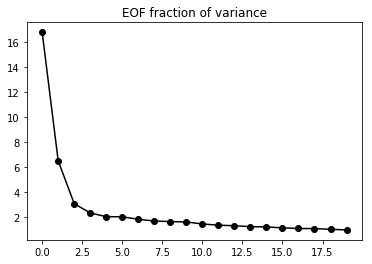

In [35]:
if var_to_extract == 'tos':
    # first tos EOF is a regridding artifact; rest look OK
    fi = 1
else:
    fi = 0
fvar = 100*s[fi:]*s[fi:]/np.sum(s[fi:]*s[fi:])
print(np.sum(fvar))
plt.plot(fvar[0:nmodes],'ko-')
plt.title('EOF fraction of variance')
print('fraction in first ',nmodes,' EOFs = ',np.sum(fvar[:nmodes]))

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


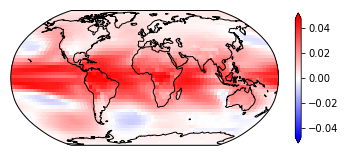

In [86]:
plot_map_vector(-u[:,0],lat_2d,lon_2d)

In [87]:
# project data onto a subset of the EOF basis

# EOF basis
if var_to_extract == 'tos':
    E = u[:,1:nmodes+1]
else:
    E = u[:,0:nmodes]

# project---this doesn't work for tos? masked array/nan issue I don't understand
#P = np.matmul(E.T,X)

# alternative from SVD results. recall v is v.T in numpy. 
# NOTE: this is the projection with W weighting, which is not the same as projecting unweighted data

# 7/13/2020: projection of unweighted data; tos doesn't work with this approach
if var_to_extract == 'tos':
    #P_w = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
    P = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
else:
    #P_w = np.matmul(np.diag(s[0:nmodes]),v[0:nmodes,:])
    P = np.matmul(E.T,X)


In [ ]:
# Multivariate - stack and standardize : 


3.988535546204542
(3240, 12012)


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


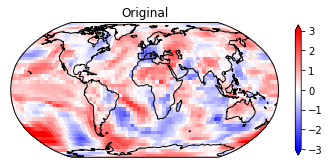

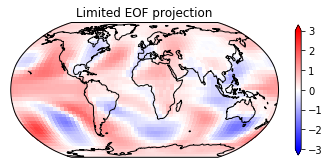

In [92]:
# reconstruct from the limited projection, and compare with the original (error)
check = np.matmul(E,P)
print(np.max(check))
print(check.shape)

# pick a random time to plot
itim = 21

plot_map_vector(X[:,itim],lat_2d,lon_2d,maxv=3)
plt.title('Original')
plt.show()
plot_map_vector(check[:,itim],lat_2d,lon_2d,maxv=3)
plt.title('Limited EOF projection')
plt.show()


In [93]:
# make sure P has zero mean first !!!
Pzero = np.max(np.abs(np.mean(P,axis=1)))
if Pzero > 1e-6:
    print('warning!!! the projected state does not have zero-mean in the time domain '
         )

In [94]:
# prepare the data to train and test the LIM. separate data into training the validation sets 
tsamp = P.shape[1]

train_inds = np.arange(0,ntrain)
valid_inds = np.arange(ntrain,tsamp,1)
x_train = P[:,train_inds]
x_valid = P[:,valid_inds]
print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)


training data shape:  (20, 4000)
validation data shape:  (20, 8012)


In [96]:
# climo standardized variance for error normalization in training and validation (1=no skill)
train_var = np.var(np.matmul(E,x_train),axis=1,ddof=1)
valid_var = np.var(np.matmul(E,x_valid),axis=1,ddof=1)

In [100]:
# train the LIM
LIMd = LIM_train(tau,x_train)

In [101]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = np.arange(13)
#lags = [0,3,6,12]
ntims = len(lags)

# training data
LIMfd_train = LIM_forecast(LIMd,x_train,lags,E)

# validation data
LIMfd_valid = LIM_forecast(LIMd,x_valid,lags,E)


t= 0


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part


t= 1


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12
t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12


In [102]:
# proper area-weighted global-mean values, including climo variance
train_gm_err,_,_ = LMR_utils.global_hemispheric_means(np.moveaxis(np.reshape(LIMfd_train['error'],
                                                                             [nlat,nlon,ntims]),-1,0),lat_2d[:,0])
train_gm_var,_,_ = LMR_utils.global_hemispheric_means(np.reshape(train_var[:,None],[nlat,nlon]),lat_2d[:,0])
valid_gm_err,_,_ = LMR_utils.global_hemispheric_means(np.moveaxis(np.reshape(LIMfd_valid['error'],[nlat,nlon,ntims]),-1,0),lat_2d[:,0])
valid_gm_var,_,_ = LMR_utils.global_hemispheric_means(np.reshape(valid_var[:,None],[nlat,nlon]),lat_2d[:,0])


Text(0.5,1,'LIM normalized global error variance')

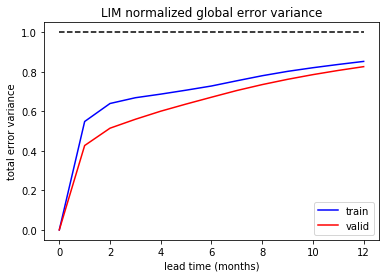

In [103]:
# plot global-mean normalized error variance
plt.plot(lags,train_gm_err/train_gm_var,'b-',label='train')
plt.plot(lags,valid_gm_err/valid_gm_var,'r-',label='valid')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_error_growth_1_6_12months',dpi=300)


In [109]:
X.shape

(3240, 12012)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


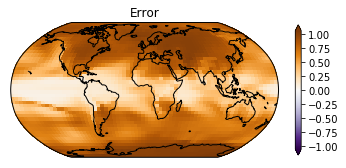

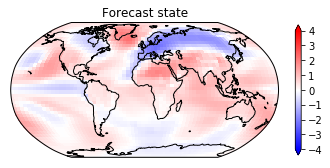

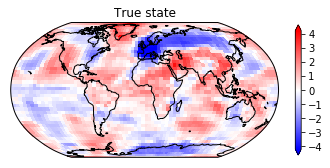

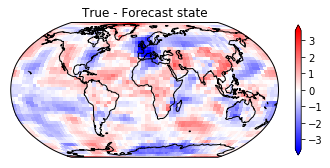

In [114]:
# plot maps of select forecasts and errors for a chosen lag in months (and time, itime)
ilag = 1
plot_map_vector(LIMfd_train['error'][:,ilag]/train_var,lat_2d,lon_2d,cmap='PuOr_r')
plt.title('Error')
plt.show()
itime = 1
plot_map_vector(np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),lat_2d,lon_2d,minv=-4,maxv=4 )
plt.title('Forecast state')
plt.show()
plot_map_vector(X[:,itime],lat_2d,lon_2d)
plt.title('True state')
plt.show()
plot_map_vector(X[:,itime] -np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),lat_2d,lon_2d)
plt.title('True - Forecast state')
plt.show()


In [27]:
# load 20cr data for independent validation...
data_20cr,_,_ = get_data(var_to_extract,infile_20cr_tas)
ntime_20cr = data_20cr.shape[0]

fetching  tas  from  /Users/hakim/data/LMR_python3/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc
-----------------------------------------------------
completed in 1.5343828201293945 seconds
-----------------------------------------------------
(1932, 91, 180)
indlat= 0  indlon= 1
('lat', 'lon')
nlat: 91
nlon: 180
(16380, 1932)
-----------------------------------------------------
completed in 0.4089019298553467 seconds
-----------------------------------------------------
0
1
2
3
4
5
6
7
8
9
10
11


In [28]:
# back to (nx,ntime)
X_20cr = np.moveaxis(np.reshape(data_20cr,[ntime_20cr,nlat*nlon]),0,-1) 

In [29]:
# test the LIM on 20CR monthly data projected on the same basis
P_20cr = np.matmul(E.T,X_20cr)

In [30]:
# climo standardized variance
valid_var_20cr = np.var(np.matmul(E,P_20cr),axis=1,ddof=1)

In [31]:
# CCSM LIM forecasts on 20cr states
LIMfd_20cr = LIM_forecast(LIMd,P_20cr,lags,E)

t= 0
t= 1
t= 2


/anaconda3/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12


In [32]:
# proper area-weighted global-mean values
valid_gm_err_20cr,_,_ = LMR_utils.global_hemispheric_means(np.moveaxis(np.reshape(LIMfd_20cr['error'],[nlat,nlon,ntims]),-1,0),lat_2d[:,0])
valid_gm_var_20cr,_,_ = LMR_utils.global_hemispheric_means(np.reshape(valid_var_20cr[:,None],[nlat,nlon]),lat_2d[:,0])


Text(0.5,1,'LIM normalized global error variance')

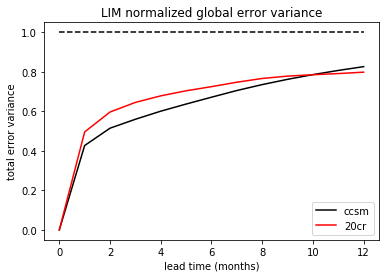

In [33]:
plt.plot(lags,valid_gm_err/valid_gm_var,'k-',label='ccsm')
plt.plot(lags,valid_gm_err_20cr/valid_gm_var_20cr,'r-',label='20cr')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_forecast_error_ccsm_20cr_6mo',dpi=300)


### Numerical integration: compare explicit integration with noise, and deterministic

In [480]:
# noise covariance matrix
L = np.matmul(np.matmul(LIMd['vec'],np.diag(LIMd['lam'])),LIMd['veci'])
C_0 = np.matmul(x_train,x_train.T)/(x_train.shape[1]-1)

Q = -1.*(np.matmul(L,C_0) + np.matmul(C_0,np.conj(L).T))

#print(Q)
print('Q symmetry check: ',np.max(np.abs(Q-np.conj(Q).T)))
# check to make sure Q has positive eigenvalues
[qe,ev] = np.linalg.eig(Q)
#print('Q eigevalues:',qe)
print('trace Q check:',np.max(np.abs(np.trace(Q)-np.sum(qe))))
print('Q similarity check:',np.max(np.abs(Q-np.matmul(np.matmul(ev,np.diag(qe)),np.conj(ev).T))))

Q symmetry check:  3.552713678800501e-15
trace Q check: 5.684352728092187e-13
Q similarity check: 9.237482563867542e-14


In [485]:
# normalize Q to have only positive eigenvalues
ev_fix = np.copy(ev)
qe_fix = np.copy(qe)
for k in range(len(qe)):
    if np.real(qe)[k] < 0.:
        print('negative eigenvalue:',k,qe[k])
        #ev_fix[:,k] = 0.
        #qe_fix[k] = 0.
        #qe_fix[k+1] = 0.
        # custom/peculiar(?) to this particular LIM and configuration
        qe_fix[k] = qe_fix[k+1]
        
# preserve the trace
qe_fix = qe_fix*np.sum(qe)/np.sum(qe_fix)
Q_fix = np.matmul(np.matmul(ev,np.diag(qe_fix)),np.conj(ev_fix).T)
print('trace check:',np.trace(Q_fix),np.trace(Q),np.sum(qe))

[qe_new,ev_new] = np.linalg.eig(Q_fix)
#print('new Q eigevalues:',qe_new)

# square root of noise covariance for numerical integration
[u,s,v] = np.linalg.svd(Q_fix)
#print(s)
Qsr = np.matmul(u,np.diag(np.sqrt(s)))
print('square root check:',np.max(np.abs(Q_fix - np.matmul(Qsr,np.conj(Qsr).T))))

negative eigenvalue: 6 (-1.912496225154809+8.721143723899629e-16j)
trace check: (763.9711139153253+1.3183898417423734e-16j) (763.9711139153256+0j) (763.9711139153251-1.1102230246252208e-15j)
square root check: 2.1316300142831556e-13


In [487]:
# add Qsr to the LIM dictionary
LIMd['Qsr'] = Qsr
print(LIMd.keys())


dict_keys(['vec', 'veci', 'lam', 'Qsr'])


In [482]:
# numerically integrate from zero initial condition

# length of integration in months
nmo = 12*100

# time step in months
dt = 1./(30*24*8) # this is ~3 hours as in Penland & Sardeshmukh

# sample once a month
tsamp = np.int(1./dt)

# total number of timesteps
nsteps = nmo*tsamp

x_save = np.zeros([nmodes,nmo])
y_old = np.zeros([nmodes,1])
k = -1
for t in range(nsteps):
    x_new,y_new = euler_twostep(L,Qsr,dt,y_old)
    y_old = np.copy(y_new)
    if np.mod(t,tsamp)==0:
        #print(t,tsamp,k)
        k += 1
        x_save[:,k] = x_new[:,0]
        

/anaconda3/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


In [483]:
print('nmo=',nmo)
#print(np.max(np.abs(np.imag(x_save))))
#print(np.mean(x_save,axis=1))
xsp = x_save - np.mean(x_save,axis=1,keepdims=True)
Cint = np.matmul(xsp,xsp.T)/(nmo-1)
print(Cint[0,0])
print('--')
print(C_0[0,0])
print(np.trace(Cint),np.trace(C_0),np.trace(Cint)/np.trace(C_0))
Cratio = np.diag(Cint)/np.diag(C_0)
print(Cratio)


nmo= 1200
230.99360225519249
--
241.5664440785889
1000.8322315127579 1296.9946675229114 0.771654854544788
[0.95623216 0.87086276 0.80167563 0.74262293 0.73934211 0.70549481
 0.63336131 0.79831838 0.77136913 0.82477455 0.44840585 0.72056132
 0.57070657 0.59751842 0.71691858 0.67088965 0.68104089 0.69806315
 0.79252766 0.72503791]


In [484]:
# how well does the estimate C get the right sign for each entry in C?
print(np.sum((Cint/C_0)>0)/(20*20))

0.735


In [ ]:
"""
Three experiments to extend the Ornstein-Uhlenbeck result
1. full integration for valid ICs
2. same, but for deterministic propagator only
3. full integration of noise for zero ICs

use the sum of 2 and 3 to check the recovery of 1
"""

In [490]:
# 1. full integration for valid ICs

# lag in months
lag = 18
# number of samples (runs)
nsamp = 200

# scale the initial ensemble variance
IC = 0.5*x_valid[:,:nsamp]

nsteps = lag*tsamp

x_save = np.zeros([lag+1,nmodes,nsamp])
for k in range(nsamp):
    print(k,nsamp)
    y_old = IC[:,k]
    it = 0
    x_save[it,:,k] = y_old
    for t in range(1,nsteps+1,1):
        x_new,y_new = euler_twostep(L,Qsr,dt,y_old)        
        y_old = np.copy(y_new)
        if np.mod(t,tsamp)==0:
            it += 1
            #print(t,tsamp,it)
            x_save[it,:,k] = x_new[:,0]
        

0 200


/anaconda3/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


1 200
2 200
3 200
4 200
5 200
6 200
7 200
8 200
9 200
10 200
11 200
12 200
13 200
14 200
15 200
16 200
17 200
18 200
19 200
20 200
21 200
22 200
23 200
24 200
25 200
26 200
27 200
28 200
29 200
30 200
31 200
32 200
33 200
34 200
35 200
36 200
37 200
38 200
39 200
40 200
41 200
42 200
43 200
44 200
45 200
46 200
47 200
48 200
49 200
50 200
51 200
52 200
53 200
54 200
55 200
56 200
57 200
58 200
59 200
60 200
61 200
62 200
63 200
64 200
65 200
66 200
67 200
68 200
69 200
70 200
71 200
72 200
73 200
74 200
75 200
76 200
77 200
78 200
79 200
80 200
81 200
82 200
83 200
84 200
85 200
86 200
87 200
88 200
89 200
90 200
91 200
92 200
93 200
94 200
95 200
96 200
97 200
98 200
99 200
100 200
101 200
102 200
103 200
104 200
105 200
106 200
107 200
108 200
109 200
110 200
111 200
112 200
113 200
114 200
115 200
116 200
117 200
118 200
119 200
120 200
121 200
122 200
123 200
124 200
125 200
126 200
127 200
128 200
129 200
130 200
131 200
132 200
133 200
134 200
135 200
136 200
137 200
138 200
139 

In [491]:
# ensemble forecast variance as a function of lead time
lvar = np.zeros([lag])
for k in range(lag):
    tmp = np.squeeze(x_save[k,:,:])
    tmp2 = tmp - np.mean(tmp,axis=1,keepdims=True)
    Ct = np.matmul(tmp2,tmp2.T)/(tmp2.shape[1]-1)
    lvar[k] = np.trace(Ct) 

In [492]:
# 2. deterministic forecasts
x_save_det = LIM_forecast(LIMd,IC,np.arange(lag),E)

t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8


/anaconda3/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


t= 9
t= 10
t= 11
t= 12
t= 13
t= 14
t= 15
t= 16
t= 17


In [493]:
# ensemble forecast variance as a function of lead time
fdet = x_save_det['x_forecast']
lvar_det = np.zeros([lag])
for k in range(lag):
    tmp = np.squeeze(fdet[k,:,:])
    tmp2 = tmp - np.mean(tmp,axis=1,keepdims=True)
    Ct = np.matmul(tmp2,tmp2.T)/(tmp2.shape[1]-1)
    lvar_det[k] = np.trace(Ct) 


In [494]:
# 3. full integration for zero ICs; build the noise covariance as a function of lead time
x_save = np.zeros([lag+1,nmodes,nsamp])
for k in range(nsamp):
    print(k,nsamp)
    # zero IC
    y_old = np.zeros([nmodes])
    it = 0
    x_save[it,:,k] = y_old
    for t in range(1,nsteps+1,1):
        x_new,y_new = euler_twostep(L,Qsr,dt,y_old)        
        y_old = np.copy(y_new)
        if np.mod(t,tsamp)==0:
            it += 1
            x_save[it,:,k] = x_new[:,0]
        

0 200


/anaconda3/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


1 200
2 200
3 200
4 200
5 200
6 200
7 200
8 200
9 200
10 200
11 200
12 200
13 200
14 200
15 200
16 200
17 200
18 200
19 200
20 200
21 200
22 200
23 200
24 200
25 200
26 200
27 200
28 200
29 200
30 200
31 200
32 200
33 200
34 200
35 200
36 200
37 200
38 200
39 200
40 200
41 200
42 200
43 200
44 200
45 200
46 200
47 200
48 200
49 200
50 200
51 200
52 200
53 200
54 200
55 200
56 200
57 200
58 200
59 200
60 200
61 200
62 200
63 200
64 200
65 200
66 200
67 200
68 200
69 200
70 200
71 200
72 200
73 200
74 200
75 200
76 200
77 200
78 200
79 200
80 200
81 200
82 200
83 200
84 200
85 200
86 200
87 200
88 200
89 200
90 200
91 200
92 200
93 200
94 200
95 200
96 200
97 200
98 200
99 200
100 200
101 200
102 200
103 200
104 200
105 200
106 200
107 200
108 200
109 200
110 200
111 200
112 200
113 200
114 200
115 200
116 200
117 200
118 200
119 200
120 200
121 200
122 200
123 200
124 200
125 200
126 200
127 200
128 200
129 200
130 200
131 200
132 200
133 200
134 200
135 200
136 200
137 200
138 200
139 

In [510]:
# ensemble forecast variance as a function of lead time
lvar_noicvar = np.zeros([lag])
Q_t = np.zeros([lag+1,nmodes,nmodes])
for k in range(lag):
    tmp = np.squeeze(x_save[k,:,:])
    tmp2 = tmp - np.mean(tmp,axis=1,keepdims=True)
    Ct = np.matmul(tmp2,tmp2.T)/(tmp2.shape[1]-1)
    lvar_noicvar[k] = np.trace(Ct)
    # save noise covariance as a function of lead time
    Q_t[k,:,:] = Ct

In [525]:
# add Q_t and lags to the LIM dictionary 
LIMd['Q_t'] = Q_t
LIMd['lags'] = np.arange(lag)
print(LIMd.keys())

dict_keys(['vec', 'veci', 'lam', 'Qsr', 'Q_t', 'lags'])


In [496]:
# climo variance for comparison
tmp = np.squeeze(x_valid[:,:nsamp])
tmp2 = tmp - np.mean(tmp,axis=1,keepdims=True)
Cc = np.matmul(tmp2,tmp2.T)/(tmp2.shape[1]-1)
climo_var = np.trace(Cc)
ICvar = np.trace(np.matmul(IC-np.mean(IC,axis=1,keepdims=True),(IC - np.mean(tmp,axis=1,keepdims=True)).T)/(IC.shape[1]-1))

Text(0,0.5,'ensemble variance')

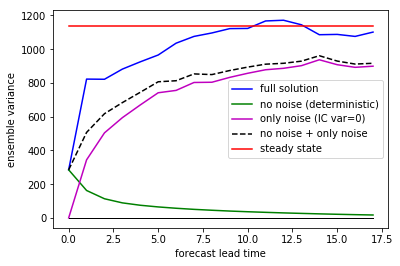

In [501]:
plt.plot(range(lag),lvar,'b-',label='full solution')
plt.plot(range(lag),lvar_det,'g-',label='no noise (deterministic)')
plt.plot(range(lag),lvar_noicvar,'m-',label='only noise (IC var=0)')
plt.plot(range(lag),lvar_noicvar+lvar_det,'k--',label='no noise + only noise')
plt.plot(range(lag),np.ones([lag])*climo_var,'r-',label='steady state')
plt.plot(range(lag),np.zeros([lag]),'k-',linewidth=1)
#plt.plot(0,ICvar,'ko')
plt.legend()
plt.xlabel('forecast lead time')
plt.ylabel('ensemble variance')

In [545]:
# add ancillary data to the LIM dictionary and save to a file
README = \
'''
This dictionary contains information about the LIM generated by LIM_testing.ipynb
* vec,veci, and lam contain the eigenvector/eigenvalue decomposition for L
* G(t) = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
* Qsr is the square root of the noise covariance matrix
* Q_t is the forecast error covariance matrix for zero IC subject to noise forcing
* lags is the lag times for the entries in Q_t
* data_source is the source for the LIM calibration
* var_to_extract: the variable for the LIM
* ntrain: training data comes from the 0:ntrain time entries in the data
* tau: lead time for the LIM calibration
* nmodes: EOF truncation
'''
LIMd['README'] = README
LIMd['var_to_extract'] = var_to_extract
LIMd['nmodes'] = nmodes
LIMd['tau'] = tau
LIMd['data_source'] = data_source
LIMd['ntrain'] = ntrain
print(LIMd.keys())
print(LIMd['README'])
filen = 'LIM_'+data_source+'_'+var_to_extract+'_tau_'+str(tau)+'.npy'
print(filen)
np.save(filen,LIMd)

dict_keys(['vec', 'veci', 'lam', 'Qsr', 'Q_t', 'lags', 'README', 'var_to_extract', 'nmodes', 'tau', 'data_source', 'ntrain'])

This dictionary contains information about the LIM generated by LIM_testing.ipynb
* vec,veci, and lam contain the eigenvector/eigenvalue decomposition for L
* G(t) = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
* Qsr is the square root of the noise covariance matrix
* Q_t is the forecast error covariance matrix for zero IC subject to noise forcing
* lags is the lag times for the entries in Q_t
* data_source is the source for the LIM calibration
* var_to_extract: the variable for the LIM
* ntrain: training data comes from the 0:ntrain time entries in the data
* tau: lead time for the LIM calibration
* nmodes: EOF truncation

LIM_CCSM4 last millennium simulation_tas_tau_6.npy


In [34]:
# to do: 
#* make sum over global error variance equal area DONE
#* start tau-test implementation IN PROGRESS
#* validate this LIM on 20CR monthly T fields DONE
#* add sea ice to the LIM? different grid? deal with bias?

#-----everything below this point is either testing or broken----

In [ ]:
#----older stuff below-----

In [35]:
# tau tests (modified from Penland2019 notebook)
# number of lags to check, with one time unit spacing
ntau = 24
norm_save = np.zeros(ntau)
sig_save = np.zeros([ntau,nmodes])
omeg_save = np.zeros([ntau,nmodes])
lam_save = np.zeros([ntau,nmodes],dtype=complex)

tau_range = np.arange(1,ntau+1)
k = -1
for t in tau_range:
    k+=1
    print('tau=',t)
    nsamp = ntrain - t - 1
    x_0 = x_train[:,t:]
    x_tau = x_train[:,:-t]
    C_0 = np.matmul(x_0-np.mean(x_0,1,keepdims=True),(x_0-np.mean(x_0,1,keepdims=True)).T)/(nsamp-1)
    C_tau = np.matmul(x_0-np.mean(x_0,1,keepdims=True),(x_tau-np.mean(x_tau,1,keepdims=True)).T)/(nsamp-1)
    #print(x_train[:,t:].shape,nsamp,(x_0-np.mean(x_0,1,keepdims=True)).shape)
    G = np.matmul(C_tau,np.linalg.inv(C_0))
    val,vec = np.linalg.eig(G)
    veci = np.linalg.inv(vec)
    lam = np.log(val)/t
    L_train = np.matmul(np.matmul(vec,np.diag(lam)),veci)
    [u,s,v] = np.linalg.svd(L_train)
    # save stuff for plotting and analysis
    norm_save[k] = np.sum(s*s)
    sig_save[k,:] = -np.real(lam)
    omeg_save[k,:] = np.imag(lam)
    lam_save[k,:] = lam


tau= 1
tau= 2
tau= 3
tau= 4
tau= 5
tau= 6
tau= 7
tau= 8
tau= 9
tau= 10
tau= 11
tau= 12
tau= 13
tau= 14
tau= 15
tau= 16
tau= 17
tau= 18
tau= 19
tau= 20
tau= 21
tau= 22
tau= 23
tau= 24


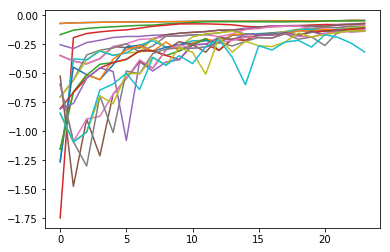

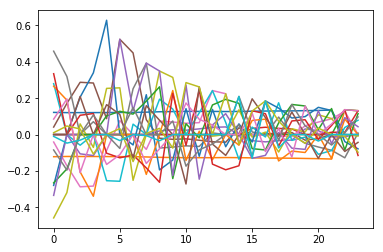

In [36]:
for k in range(nmodes):
    plt.plot(np.real(lam_save[:,k]))
plt.show()
for k in range(nmodes):
    plt.plot(np.imag(lam_save[:,k]))
    

In [37]:
def mode_check(lam,lam_ref,tau):
    """
    Function to find a matching eigenvalues in a list, accounting for multivalue complex ln. 

    Strategy:
    * assume a reference eigenvalue (from other tau, average over tau, or whatever): lam_ref
    * for eigenvalues find the closest match between lam, lam + 2i\pi, lam - 2\pi

    Inputs:
    * lam: a single log eigenvalue from a LIM fit on tau. Specifically, lam = ln(g_i)/tau
    * lam_ref: a list of reference eigenvalue to search for a multivalued match with lam
    * tau: the lead time

    Outputs:
    * the index of the entry of the matching eigenvalue in lam_ref
    * the matching eigenvalue in the reference
    * the magnitude of the difference between the eigenvalue and the closest reference eigenvalue
    """
    ndof = len(lam_ref)
    tmp = np.copy(lam_ref)
    tmp2 = np.concatenate((tmp,tmp+(2j*pi/tau)))
    tmp3 = np.concatenate((tmp2,tmp-(2j*pi/tau)))
    nrm = np.abs(tmp3-lam)
    imatch = np.argmin(nrm)
    if imatch < ndof:
        ii = imatch
    elif (imatch >= ndof) & (imatch < 2*ndof):
        ii = imatch - ndof
    else:
        ii = imatch - 2*ndof

    return ii,lam_ref[ii],nrm[imatch]

In [ ]:
# This doesn't work....

# this matrix holds the corrected values as a function of lag
lam_fix = np.zeros([ntau,nmodes],dtype=complex)
# the first time is assumed correct
lam_fix[0,:] = lam_save[0,:]

# critical value for eigenvalue difference. above this, the tau test is assumed failed
nrm_crit = 0.1

k = 0
for t in tau_range[1:]:
    k+=1
    print('--- time ',t,' ---')
    mlist = lam_save[0,:].tolist()
    for mode in range(nmodes):
        ii,newlam,nrm = mode_check(lam_save[k,mode],mlist,tau[k])
        print(mode,ii,lam_save[0,mode],newlam)
        lam_fix[k,mode] = newlam
        mlist.pop(ii)
        if nrm > nrm_crit:
            print('!!! the tau test has failed !!!',nrm,'>',nrm_crit)

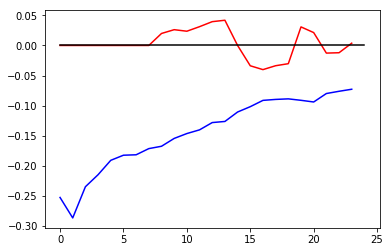

In [39]:
ilam = 4
plt.plot(np.real(lam_save[:,ilam]),'b-')
plt.plot(np.imag(lam_save[:,ilam]),'r-')
plt.plot([0,ntau],[0,0],'k-')

In [40]:
#---- old work, but potentialy useful, below here ----

In [41]:
# rmse for random states
errt = np.zeros([nmodes,ntrain])
for k in range(ntrain-1):
    ir = np.random.randint(ntrain-1)
    errt[:,k] = x_train[:,k] - x_train[:,ir]

rmsee = np.sqrt(np.mean(errt*np.conj(errt),axis=1))

In [42]:
plt.plot(times,rmses[0,:])
plt.plot(times,rmses[1,:])
plt.plot(times,rmses[2,:])
plt.plot(times,rmses[3,:])
plt.plot([0,nmonths],[rmsee[0],rmsee[0]],'b--')
plt.plot([0,nmonths],[rmsee[1],rmsee[1]],'y--')
plt.plot([0,nmonths],[rmsee[2],rmsee[2]],'g--')
plt.plot([0,nmonths],[rmsee[3],rmsee[3]],'r--')


NameError: name 'times' is not defined

In [ ]:
# verification
#rmse = np.sqrt(np.mean(error*np.conj(error),axis=1))
#rmses[:,k] = rmse

In [ ]:
plot_map_vector(data_var[3,:,:],lat_2d_orig,lon_2d_orig,minv=260,maxv=300,noland=noland)

In [ ]:
plot_map_vector(data_new[:,3],lat_2d,lon_2d,minv=260,maxv=300,noland=noland)